We have data containing user information such as their userID, age, income, and sex. We also have the target variable, signifying whether they purchased an SUV based on an online ad. Our task is to create a support vector classifier capable of predicting web purchases of SUVs based on the data.

In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn import svm, datasets
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, \
f1_score, classification_report,ConfusionMatrixDisplay
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.utils.class_weight import compute_class_weight

## **Load dataset**

In [42]:
# Load dataset and view first five lines
social_df = pd.read_csv('social.csv')
social_df.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19.0,19000.0,0
1,15810944,Male,35.0,20000.0,0
2,15668575,Female,26.0,43000.0,0
3,15603246,Female,27.0,57000.0,0
4,15804002,Male,19.0,76000.0,0


In [43]:
# Understand the data types of our dataset
social_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   User ID          400 non-null    int64  
 1   Gender           400 non-null    object 
 2   Age              400 non-null    float64
 3   EstimatedSalary  400 non-null    float64
 4   Purchased        400 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 15.8+ KB


In [44]:
# Check the balance of the target variable
social_df['Purchased'].value_counts()

0    257
1    143
Name: Purchased, dtype: int64

We notice imbalance between the two classes which we will take care before we fit the model.

In [45]:
# Check for missing values
social_df.isnull().sum()

User ID            0
Gender             0
Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

## **Preprocessing**

In [46]:
# Change 'Age' data type to integer
social_df['Age'] = social_df['Age'].astype(int)

We drop also User ID and Gender since they don't offer any value in the predictions.

In [47]:
# Data Preprocessing
target = social_df['Purchased']
inputs = social_df.drop(['User ID', 'Gender', 'Purchased'],axis=1)

In [48]:
# Scale the 'EstimatedSalary' column to [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))
inputs['EstimatedSalary'] = scaler.fit_transform(inputs['EstimatedSalary'].values.reshape(-1, 1))

## **Create a training and a testing dataset**

In [49]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(inputs, target, test_size=0.3, random_state=42, stratify = target)

In [50]:
# Compute class weights based on the class distribution in the training data
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)

In [51]:
# Create a linear SVM classifier with C=1
svm_classifier = svm.SVC(kernel='linear', C=1, class_weight={0: class_weights[0], 1: class_weights[1]})

# Fit the classifier on the training data
svm_classifier.fit(x_train, y_train)

# Predict the labels for the test data
y_pred = svm_classifier.predict(x_test)

# Evaluate the performance of the classifier
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Accuracy: 0.8
Precision: 0.6727272727272727
Recall: 0.8604651162790697
F1-score: 0.7551020408163266


In [52]:
print(classification_report(y_test, y_pred, target_names=["Not Buy", "Buy"]))

              precision    recall  f1-score   support

     Not Buy       0.91      0.77      0.83        77
         Buy       0.67      0.86      0.76        43

    accuracy                           0.80       120
   macro avg       0.79      0.81      0.79       120
weighted avg       0.82      0.80      0.80       120



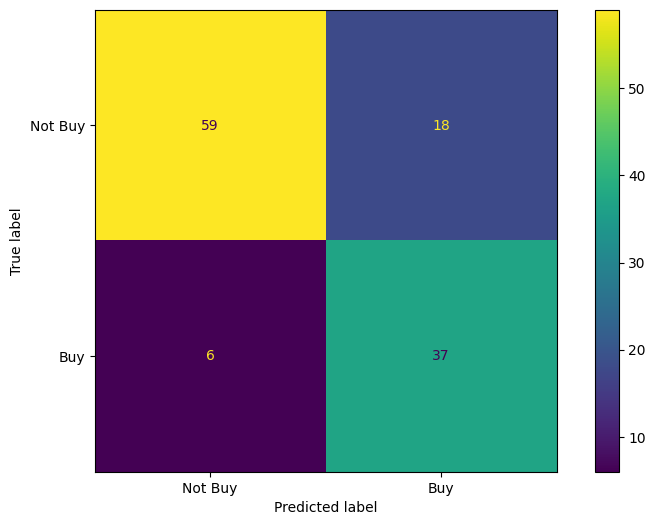

In [53]:
# Plot the confusion matrix
fig, ax = plt.subplots(figsize= (10,6))

cmp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=["Not Buy", "Buy"])
cmp.plot(ax=ax)

## **Hyperparameter Tuning**

In [54]:
tuned_params = [
    {'kernel': ['linear'], 'C': [0.1, 1, 10, 100, 1000]},
     {'kernel': ['poly'], 'C': [0.1, 1, 10, 100, 1000]},
     {'kernel': ['rbf'], 'gamma' : [1e-3, 1e-4], 'C': [0.1, 1, 10, 100, 1000]}
]

In [55]:
scores = ["precision", "recall"]

In [56]:
# Find the best combination of hyperparameters and scoring metric
best_score = 0
best_params = None

for score in scores:
    for params in tuned_params:
        clf = GridSearchCV(svm.SVC(), params, scoring="%s_macro" % score)
        clf.fit(x_train, y_train)

        # Check if the current combination is better than the previous best
        if clf.best_score_ > best_score:
            best_score = clf.best_score_
            best_params = clf.best_params_

# Best_params for the final model and report
print("Best parameters set found:")
print(best_params)
print("Best macro-average score:", best_score)

# Create and fit the final model with the best parameters
final_model = svm.SVC(**best_params)
final_model.fit(x_train, y_train)

# Evaluate the final model on the test data
y_true, y_pred = y_test, final_model.predict(x_test)
print("Detailed classification report for the final model:")
print(classification_report(y_true, y_pred, zero_division=1))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning

Best parameters set found:
{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
Best macro-average score: 0.8756548680078092
Detailed classification report for the final model:
              precision    recall  f1-score   support

           0       0.91      0.92      0.92        77
           1       0.86      0.84      0.85        43

    accuracy                           0.89       120
   macro avg       0.88      0.88      0.88       120
weighted avg       0.89      0.89      0.89       120



## **Plotting the decision boundaries of SVC**

In [57]:
knn_palette = sns.color_palette([ '#29757A', '#FF5050'])
knn_palette

[(0.1607843137254902, 0.4588235294117647, 0.47843137254901963),
 (1.0, 0.3137254901960784, 0.3137254901960784)]

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


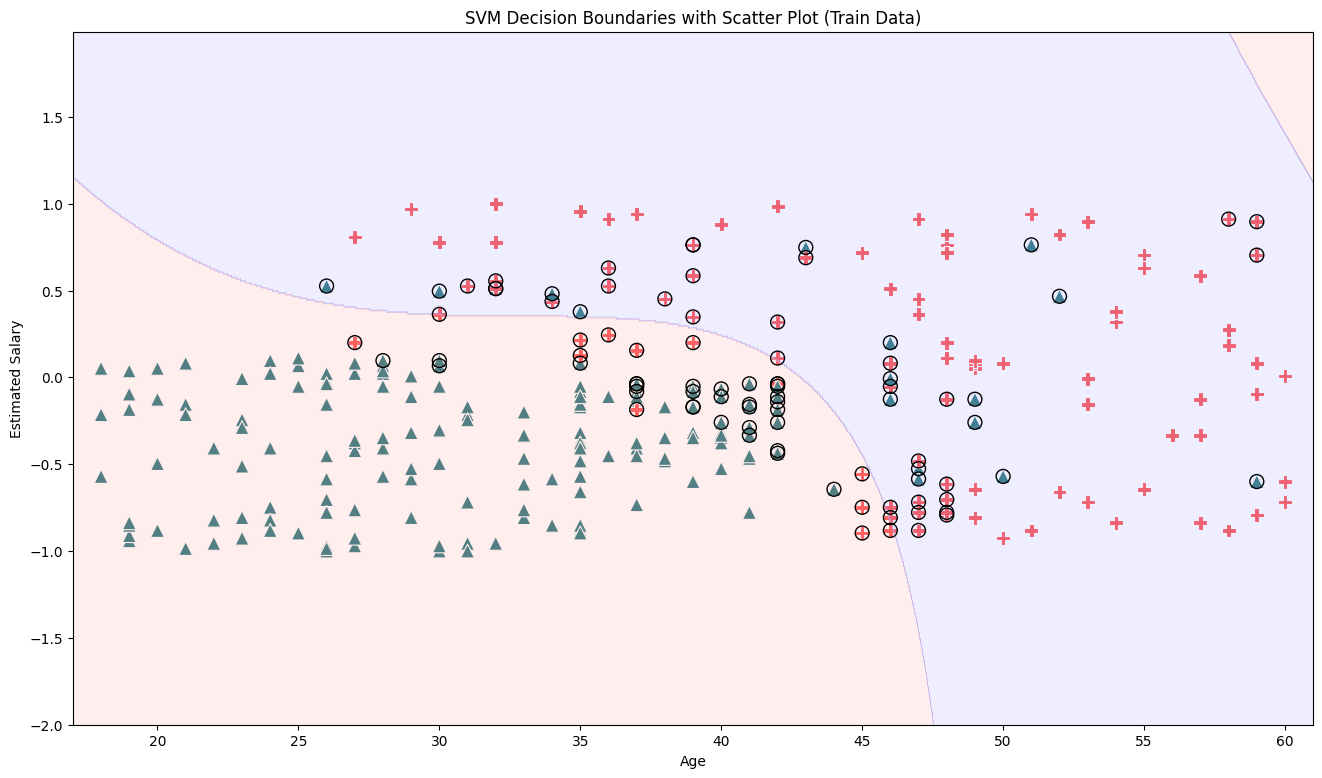

In [70]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Create a scatter plot as you did before
plt.figure(figsize=(16, 9))
sns.scatterplot(x=x_train['Age'], y=x_train['EstimatedSalary'],
                data=social_df,
                hue='Purchased',
                palette=knn_palette,
                markers=['^', 'P'],
                style='Purchased',
                s=100,
                alpha=1,
                legend=False)

# Create a mesh grid for decision boundary visualization
x_min, x_max = x_train['Age'].min() - 1, x_train['Age'].max() + 1
y_min, y_max = x_train['EstimatedSalary'].min() - 1, x_train['EstimatedSalary'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict the class labels for each grid point
Z = final_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape Z to the shape of xx
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.2)

# Add labels and a title to the plot
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.title('SVM Decision Boundaries with Scatter Plot (Train Data)')

# Highlight the support vectors
plt.scatter(final_model.support_vectors_[:, 0], final_model.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k')

# Show the combined plot
plt.show()

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


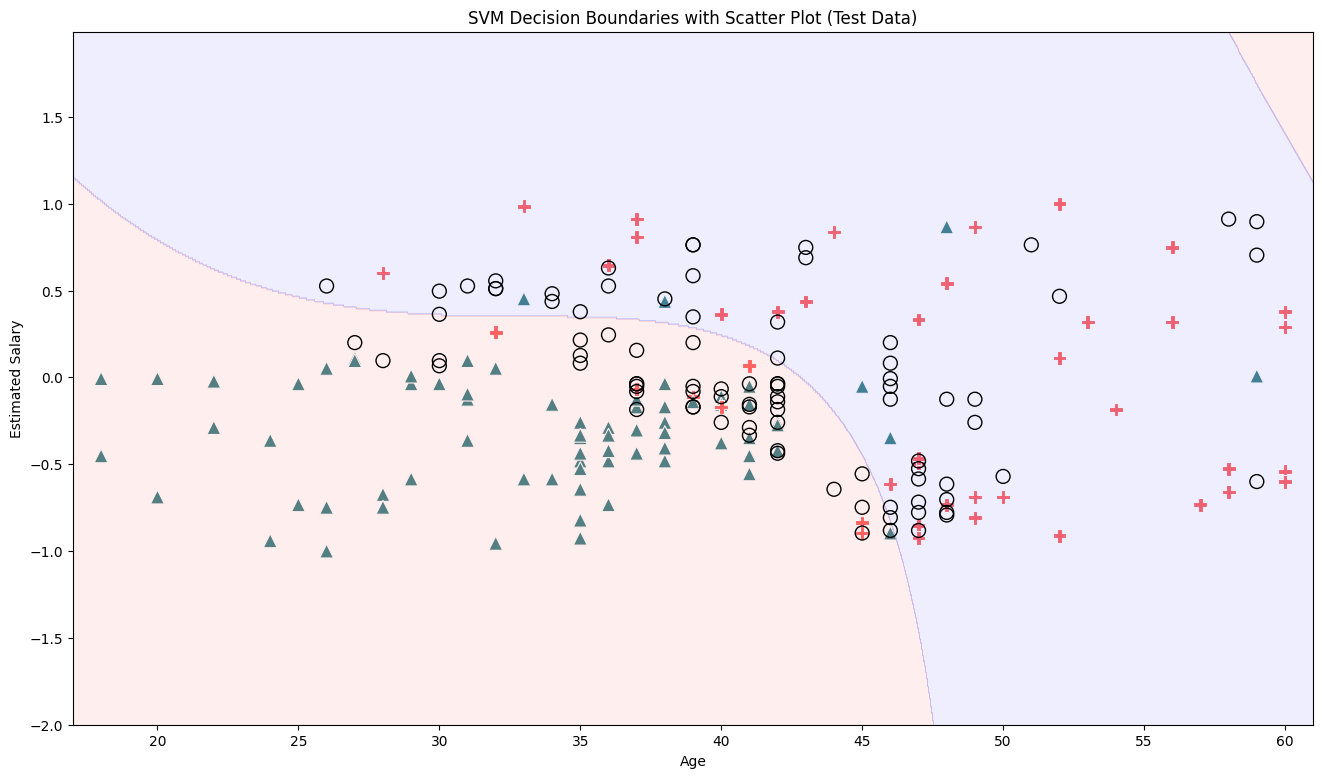

In [69]:
# Create a scatter plot for the test data
plt.figure(figsize=(16, 9))
sns.scatterplot(x=x_test['Age'], y=x_test['EstimatedSalary'],
                data=social_df,
                hue='Purchased',
                palette=knn_palette,
                markers=['^', 'P'],
                style='Purchased',
                s=100,
                alpha=1,
                legend=False)

# Create a mesh grid for decision boundary visualization using the test data
x_min, x_max = x_test['Age'].min() - 1, x_test['Age'].max() + 1
y_min, y_max = x_test['EstimatedSalary'].min() - 1, x_test['EstimatedSalary'].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))

# Predict the class labels for each grid point
Z = final_model.predict(np.c_[xx.ravel(), yy.ravel()])

# Reshape Z to the shape of xx
Z = Z.reshape(xx.shape)

# Plot the decision boundaries
cmap_background = ListedColormap(['#FFAAAA', '#AAAAFF'])
plt.contourf(xx, yy, Z, cmap=cmap_background, alpha=0.2)

# Add labels and a title to the plot
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.title('SVM Decision Boundaries with Scatter Plot (Test Data)')

# Highlight the support vectors
plt.scatter(final_model.support_vectors_[:, 0], final_model.support_vectors_[:, 1], s=100, facecolors='none', edgecolors='k')

# Show the combined plot
plt.show()